In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import seaborn as sns
import matplotlib.pyplot as plt
import random
from joblib import dump
import joblib
import copy
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
from sklearn.neighbors import NearestNeighbors
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data, DataLoader
from torch.utils.data import DataLoader, random_split
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, TensorDataset

/Users/mac/opt/anaconda3/envs/notebook/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


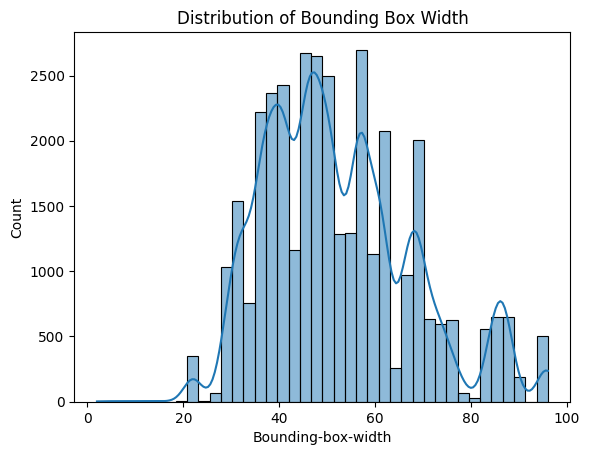

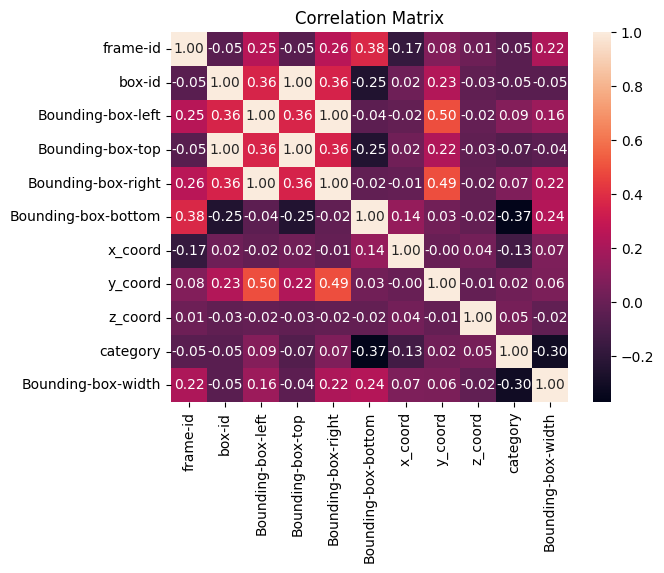

            x_coord       y_coord       z_coord      category  \
count  36000.000000  36000.000000  36000.000000  36000.000000   
mean       0.287528      0.073111      0.984833      0.766889   
std        0.452616      0.260322      0.122217      0.422818   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      1.000000      1.000000   
50%        0.000000      0.000000      1.000000      1.000000   
75%        1.000000      0.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000   

       Bounding-box-width  
count        36000.000000  
mean            52.279833  
std             15.522038  
min              2.000000  
25%             41.000000  
50%             50.000000  
75%             61.000000  
max             96.000000  


In [2]:
# Load the data

df = pd.read_csv("/Users/mac/Desktop/gnn/PFE_Feryal/all_data.csv", header=None)


df = df[0].str.split(' ', expand=True)
df.columns = ['frame-id', 'box-id', 'Bounding-box-left', 'Bounding-box-top', 'Bounding-box-right',
              'Bounding-box-bottom', 'x_coord', 'y_coord', 'z_coord', 'category']

# Data Preprocessing
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])
df['Bounding-box-width'] = pd.to_numeric(df['Bounding-box-right']) - pd.to_numeric(df['Bounding-box-left'])
df[['x_coord', 'y_coord', 'z_coord']] = df[['x_coord', 'y_coord', 'z_coord']].apply(pd.to_numeric, errors='coerce')
df = df.dropna(subset=['x_coord', 'y_coord', 'z_coord'])

# Features and Labels
input_features = df[['x_coord', 'y_coord', 'z_coord']].astype(float)
labels = df['category'].astype(int)

# Plotting
# Histogram of 'Bounding-box-width'
sns.histplot(data=df, x="Bounding-box-width", bins=40, kde=True)
plt.title('Distribution of Bounding Box Width')
plt.savefig('histogram.png')  # Save the histogram as an image file
plt.show()

# Correlation matrix
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')  # Save the correlation matrix as an image file
plt.show()

# Statistical summary
print(df.describe())



In [3]:
# Threshold for distance
threshold_distance = 10
in_channels = 3
hidden_channels = 16
num_epochs = 20
# Train-test split
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Specify the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Prepare input features and labels
train_input_features = train_df[['x_coord', 'y_coord', 'z_coord']].values.astype(np.float32)
train_labels = train_df['category'].values.astype(np.int64)
test_input_features = test_df[['x_coord', 'y_coord', 'z_coord']].values.astype(np.float32)
test_labels = test_df['category'].values.astype(np.int64)

# Create PyTorch Dataset
train_dataset = TensorDataset(torch.tensor(train_input_features), torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_input_features), torch.tensor(test_labels))
num_classes = train_dataset.tensors[1].max().item() + 1

# Create DataLoader for training and test data
batch_size =4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Move the model and data to the device
model = GraphSAGE(in_channels, hidden_channels, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define the train function
def train(model, features, edge_index, labels, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(features.float(), edge_index.long())
    loss = F.nll_loss(out, labels)
    loss.backward()
    optimizer.step()

# Define the test function
def test(model, features, edge_index, labels):
    model.eval()
    out = model(features.float(), edge_index.long())
    pred = out.argmax(dim=1)
    correct = float(pred.eq(labels).sum().item())
    acc = correct / len(labels)
    return acc, pred

# Define the function for computing adjacency matrix
def compute_adjacency_matrix(features, threshold_distance):
    # Compute distances
    node_distances = pdist(features)

    # Compute adjacency matrix
    adjacency_matrix = squareform(node_distances <= threshold_distance)

    # Normalize adjacency matrix
    adjacency_matrix = adjacency_matrix / adjacency_matrix.sum(axis=1, keepdims=True)

    return adjacency_matrix



# Training and Testing the model
for epoch in range(1, num_epochs + 1):
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        
        # Compute adjacency matrix for the batch
        batch_adjacency_matrix = compute_adjacency_matrix(batch_features.detach().cpu().numpy(), threshold_distance)
        
        # Convert adjacency matrix to edge_index tensor
        batch_edge_index = torch.tensor(np.argwhere(batch_adjacency_matrix).T, dtype=torch.long).to(device)

        # Train model on the batch
        train(model, batch_features, batch_edge_index, batch_labels, optimizer)

    # Test on the training data
    train_accuracy = []
    train_predictions = []
    for batch_features, batch_labels in train_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        batch_adjacency_matrix = compute_adjacency_matrix(batch_features.detach().cpu().numpy(), threshold_distance)
        batch_edge_index = torch.tensor(np.argwhere(batch_adjacency_matrix).T, dtype=torch.long).to(device)
        acc, pred = test(model, batch_features, batch_edge_index, batch_labels)
        train_accuracy.append(acc)
        train_predictions.extend(pred.tolist())
    train_acc = np.mean(train_accuracy)
    train_f1 = f1_score(train_labels, train_predictions, average='macro')

    # Test on the testing data
    test_accuracy = []
    test_predictions = []
    for batch_features, batch_labels in test_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        batch_adjacency_matrix = compute_adjacency_matrix(batch_features.detach().cpu().numpy(), threshold_distance)
        batch_edge_index = torch.tensor(np.argwhere(batch_adjacency_matrix).T, dtype=torch.long).to(device)
        acc, pred = test(model, batch_features, batch_edge_index, batch_labels)
        test_accuracy.append(acc)
        test_predictions.extend(pred.tolist())
    test_acc = np.mean(test_accuracy)
    test_f1 = f1_score(test_labels, test_predictions, average='macro')

    print(f'Epoch: {epoch:01d}, Train Acc: {train_acc:.9f}, Train F1: {train_f1:.9f}, Test Acc: {test_acc:.9f}, Test F1: {test_f1:.9f}')


    
# Save the model checkpoint
torch.save(model.state_dict(), 'model_GraphSAGEf.pth')


Epoch: 1, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 2, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 3, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 4, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 5, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 6, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 7, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 8, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 9, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0.433041105
Epoch: 10, Train Acc: 0.768214286, Train F1: 0.434457685, Test Acc: 0.763796296, Test F1: 0

CLient and Server Classes 


In [4]:
class MyDataset:
    def __init__(self, features, labels, adjacency_matrix):
        edge_index = adjacency_matrix.nonzero()  # Transform adjacency matrix to edge list
        edge_index = torch.tensor(edge_index, dtype=torch.long)  # Convert to tensor
        self.x = torch.tensor(features, dtype=torch.float)  # Features
        self.y = torch.tensor(labels, dtype=torch.long)  # Labels
        self.edge_index = edge_index  # Edge list

    def __str__(self):
        return f'Features shape: {self.x.shape}, Labels shape: {self.y.shape}, Edges shape: {self.edge_index.shape}'


class Client:
    def __init__(self, id, model, dataTrain, dataTest, optimizer, localep):
        self.id = id
        self.model = model
        self.dataTrain = dataTrain
        self.dataTest = dataTest
        self.optimizer = optimizer
        self.localep = localep
        self.acc = 0.0  # Store accuracy as an attribute
        self.f1 = 0.0  # Store F1 score as an attribute
        self.loss = 0.0

        
        self.round_accs = []  # List to store accuracy values after each round
        self.round_f1s = []  # List to store F1 score values after each round

        # Initialize the GraphSAGE model
        num_classes = self.dataTrain.y.max().item() + 1
        self.model = GraphSAGE(in_channels=3, hidden_channels=16, num_classes=num_classes).to(device)

    def train(self):
        loss = 0
        out = 0
        self.model.train()
        for i in range(self.localep):
            self.optimizer.zero_grad()
            out = self.model(self.dataTrain.x, self.dataTrain.edge_index)
            loss = F.cross_entropy(out, self.dataTrain.y)
            loss.backward()
            self.optimizer.step()

    def test(self):
        self.model.eval()
        out = self.model(self.dataTest.x, self.dataTest.edge_index)
        loss = F.cross_entropy(out, self.dataTest.y)
        pred = out.argmax(dim=1)
        acc = accuracy_score(self.dataTest.y.numpy(), pred.numpy())
        f1 = f1_score(self.dataTest.y.numpy(), pred.numpy(), average='weighted')
        self.acc = acc
        self.f1 = f1
        self.loss = loss
        return self.acc, self.f1, self.loss
    

class Server:
    def __init__(self, clients, global_model, FLround, FLMethod,dataVal):
        self.clients = clients
        self.global_model = global_model
        self.FLround = FLround
        self.FLMethod = FLMethod
        self.dataVal = dataVal  # validation data
        self.mutation_rate = 0.01
        self.best_models = []  # Track the best model for each round
        self.best_metric = 0.0
        self.global_best_model = None
        self.round_accs = []  # Store accuracy for each round
        self.round_f1s = []  # Store F1 score for each round

    def FedAvg(self, w):
        w_avg = copy.deepcopy(w[0])

        for k in w_avg.keys():
            for i in range(1, len(w)):
                w_avg[k] += w[i][k]
            w_avg[k] = torch.div(w_avg[k], len(w))

        return w_avg
    def fitness(self, state_dict, data):
    # Assuming `model` is your model
        model.load_state_dict(state_dict)
        model.eval()
       
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        acc = accuracy_score(data.y.numpy(), pred.numpy())
        return acc

    def selection(self, weights, fitnesses):
        idx = np.random.choice(np.arange(len(weights)), size=2, p=fitnesses/np.sum(fitnesses), replace=False)
        return weights[idx[0]], weights[idx[1]]

    def crossover(self, weight1, weight2):
        new_weight = copy.deepcopy(weight1)
        for key in new_weight.keys():
            new_weight[key] = (weight1[key] + weight2[key]) / 2
        return new_weight

    def mutate(self, weight):
        for key in weight.keys():
            noise = torch.randn_like(weight[key]) * self.mutation_rate
            weight[key] += noise
        return weight

    def FedGA(self, weights, data):
        fitnesses = np.array([self.fitness(weight, data) for weight in weights])
        new_weights = []
        for _ in range(len(weights)):
            weight1, weight2 = self.selection(weights, fitnesses)
            new_weight = self.crossover(weight1, weight2)
            new_weight = self.mutate(new_weight)
            new_weights.append(new_weight)
        return new_weights[np.argmax(fitnesses)]

    def Aggregation(self):
        weights = []
        for client in self.clients:
            client.train()
            client_model_state = client.model.state_dict()
            weights.append(client_model_state)

        if self.FLMethod == 'FedAVG':
            global_weights = self.FedAvg(weights)
        elif self.FLMethod == 'FedGA':
            global_weights = self.FedGA(weights, self.clients[0].dataTrain)  # assuming all clients have the same training data

        self.global_model.load_state_dict(global_weights)

        for client in self.clients:
            client.model.load_state_dict(global_weights)
            client.test()

    

    def display_metrics(self):
        for i, client in enumerate(self.clients):
            print(f'Client {i + 1}:')
            print(f'  Accuracy: {client.acc}')
            print(f'  F1 score: {client.f1}')

        
    def FLRounds(self):
        for rou in range(self.FLround):
            print(f'FL round {rou + 1}')
            self.Aggregation()

            # Evaluate and display metrics after each round
            self.display_metrics()

            # Collect accuracy and F1 score after each round
            round_acc = [client.acc for client in self.clients]
            round_f1 = [client.f1 for client in self.clients]
            self.round_accs.append(round_acc)
            self.round_f1s.append(round_f1)

            # Check if the current model has a higher metric value than the best model
            # Check if the current model has a higher metric value than the best model
            current_metric = max(round_acc)  # Change to round_f1 for F1 score
            if current_metric > self.best_metric:
                self.best_model = copy.deepcopy(self.global_model)
                self.best_models.append((self.best_model, current_metric))  # Store the model and its metric
                self.best_metric = current_metric

            
        
    
        

        # Display the best model for each round
        print("Best Models:")
        for i, best_model in enumerate(self.best_models):
            print(f'Round {i + 1}:')
            best_model[0].eval()

            out = best_model[0](self.clients[0].dataTest.x, self.clients[0].dataTest.edge_index)

            loss = F.cross_entropy(out, self.clients[0].dataTest.y)
            pred = out.argmax(dim=1)
            acc = accuracy_score(self.clients[0].dataTest.y.numpy(), pred.numpy())
            f1 = f1_score(self.clients[0].dataTest.y.numpy(), pred.numpy(), average='weighted')
            print(f'  Accuracy: {acc}')
            print(f'  F1 score: {f1}')

       
        # Find the global best model
        self.global_best_model = max(self.best_models, key=lambda item:item[1])[0]  # item[1] is the metric, item[0] is the model

        print("Global Best Model:")
        self.global_best_model.eval()
        out = self.global_best_model(self.clients[0].dataTest.x, self.clients[0].dataTest.edge_index)

        loss = F.cross_entropy(out, self.clients[0].dataTest.y)
        pred = out.argmax(dim=1)
        acc = accuracy_score(self.clients[0].dataTest.y.numpy(), pred.numpy())
        f1 = f1_score(self.clients[0].dataTest.y.numpy(), pred.numpy(), average='weighted')
        print(f'  Accuracy: {acc}')
        print(f'  F1 score: {f1}')
        
        
    

FLround = 20  # number of Federated Learning rounds
FLMethod = 'FedGA'  # the Federated Learning method to use
#df1 = df.iloc[:9000]
num_clients = 5

# Shuffle and split the DataFrame for client use
df = shuffle(df)
split_df = np.array_split(df, num_clients)

# Prepare the testing data for the server
#test_input_features = df1[['x_coord', 'y_coord', 'z_coord']].values.astype(np.float32)
#test_labels = df1['category'].values.astype(np.int64)

# Compute the adjacency matrices for the testing data
test_node_distances = pdist(test_input_features)
test_adjacency_matrix = squareform(test_node_distances <= threshold_distance)

# Create the MyDataset objects for the testing data
dataVal = MyDataset(test_input_features, test_labels, test_adjacency_matrix)

# Train-test split for each client
clients = []
for i in range(num_clients):
    df_i = split_df[i]
    train_df_i, test_df_i = train_test_split(df_i, test_size=0.3, random_state=40)

    # Extract the input features and labels for each client
    train_input_features_i = train_df_i[['x_coord', 'y_coord', 'z_coord']].values.astype(np.float32)
    train_labels_i = train_df_i['category'].values.astype(np.int64)
    test_input_features_i = test_df_i[['x_coord', 'y_coord', 'z_coord']].values.astype(np.float32)
    test_labels_i = test_df_i['category'].values.astype(np.int64)

    # Compute the adjacency matrices for each client
    train_node_distances_i = pdist(train_input_features_i)
    test_node_distances_i = pdist(test_input_features_i)
    train_adjacency_matrix_i = squareform(train_node_distances_i <= threshold_distance)
    test_adjacency_matrix_i = squareform(test_node_distances_i <= threshold_distance)

    # Create the MyDataset objects for each client
    train_data_i = MyDataset(train_input_features_i, train_labels_i, train_adjacency_matrix_i)
    test_data_i = MyDataset(test_input_features_i, test_labels_i, test_adjacency_matrix_i)

    # Create the model and optimizer for each client
    model = GraphSAGE(in_channels=3, hidden_channels=16, num_classes=num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Create the client
    client = Client(i, model, train_data_i, test_data_i, optimizer, localep=1)
    clients.append(client)

global_model = GraphSAGE(in_channels=3, hidden_channels=16, num_classes=num_classes)

server = Server(clients, global_model, FLround, FLMethod, dataVal)
server.FLRounds()  # Run the federated learning process

fedavg_train_accs = server.round_accs
fedavg_train_f1s = server.round_f1s

torch.save(server.global_best_model.state_dict(), "global_best_model.pth")


/var/folders/5x/wvgtdd157rq0fd42q6nf6ywr0000gn/T/ipykernel_27919/123507582.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  edge_index = torch.tensor(edge_index, dtype=torch.long)  # Convert to tensor


FL round 1
Client 1:
  Accuracy: 0.6416666666666667
  F1 score: 0.6601387725178047
Client 2:
  Accuracy: 0.638425925925926
  F1 score: 0.6586457527005447
Client 3:
  Accuracy: 0.6435185185185185
  F1 score: 0.6647829876412636
Client 4:
  Accuracy: 0.6518518518518519
  F1 score: 0.6694563208376367
Client 5:
  Accuracy: 0.6125
  F1 score: 0.6319852380393934
FL round 2
Client 1:
  Accuracy: 0.6416666666666667
  F1 score: 0.6601387725178047
Client 2:
  Accuracy: 0.638425925925926
  F1 score: 0.6586457527005447
Client 3:
  Accuracy: 0.6435185185185185
  F1 score: 0.6647829876412636
Client 4:
  Accuracy: 0.6518518518518519
  F1 score: 0.6694563208376367
Client 5:
  Accuracy: 0.6125
  F1 score: 0.6319852380393934
FL round 3
Client 1:
  Accuracy: 0.6416666666666667
  F1 score: 0.6601387725178047
Client 2:
  Accuracy: 0.638425925925926
  F1 score: 0.6586457527005447
Client 3:
  Accuracy: 0.6435185185185185
  F1 score: 0.6647829876412636
Client 4:
  Accuracy: 0.6518518518518519
  F1 score: 0.669

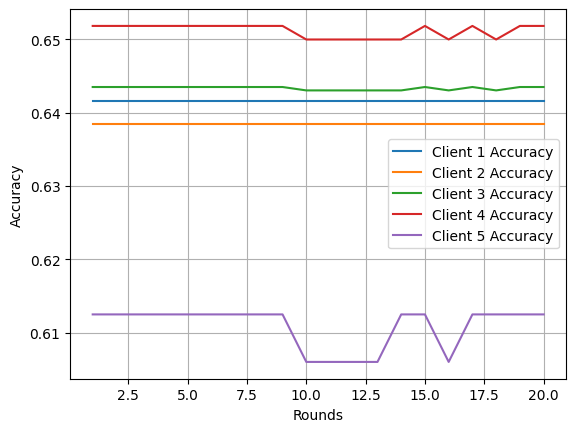

In [5]:
import matplotlib.pyplot as plt

# Plotting the metrics
fig, ax = plt.subplots()

# Create an array with the number of rounds
rounds = np.arange(1, server.FLround + 1)

for i, client_accs in enumerate(np.array(server.round_accs).T):  # Transpose to get client accuracies
    ax.plot(rounds, client_accs, label=f'Client {i+1} Accuracy')

ax.set_xlabel('Rounds')
ax.set_ylabel('Accuracy')
ax.legend()
ax.grid(True)







plt.savefig('fl_model_accuracy_comparison_FEDGA.png')

plt.show()


In [ ]:
import os
import cv2
import torch
from scipy.spatial.distance import pdist, squareform



model_yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model_yolo.eval()

threshold_distance = 10
in_channels = 3
hidden_channels = 16
num_classes = 2

model_gsage = GraphSAGE(in_channels, hidden_channels, num_classes).to(device)
model_gsage.load_state_dict(torch.load('model_GraphSAGE.pth'))
model_gsage.eval()

num_classes_fl = 2

model_fl = GraphSAGE(in_channels, hidden_channels, num_classes_fl).to(device)
model_fl.load_state_dict(torch.load('global_best_model.pth'))
model_fl.eval()

img_dir = "/Users/mac/Desktop/gnn/PFE/tf"

le = LabelEncoder()
le.fit(df['category'])

for filename in os.listdir(img_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        file_path = os.path.join(img_dir, filename)
        image = cv2.imread(file_path)
        results_yolo = model_yolo(image)

        boxes_yolo = results_yolo.xyxy[0][:, :4].detach().cpu().numpy()
        labels_yolo = results_yolo.xyxy[0][:, 5].detach().cpu().numpy()
        #labels_yolo = le.inverse_transform(labels_yolo.astype(int))  # Decode the labels

        
        for box_yolo, label_yolo in zip(boxes_yolo, labels_yolo):
            xmin, ymin, xmax, ymax = box_yolo.astype(int)
            object_region = image[ymin:ymax, xmin:xmax]
            object_region_2d = object_region.reshape(-1, object_region.shape[-1])
            num_nodes = object_region_2d.shape[0]
            object_node_distances = pdist(object_region_2d)
            object_adjacency_matrix = squareform(object_node_distances <= threshold_distance)
            object_adjacency_matrix = object_adjacency_matrix / object_adjacency_matrix.sum(axis=1, keepdims=True)
            object_edge_index = torch.tensor(np.argwhere(object_adjacency_matrix).T, dtype=torch.long)
            object_tensor = torch.tensor(object_region_2d, dtype=torch.float32)
            gcn_outputs = model_gsage(object_tensor, object_edge_index)
            fl_outputs = model_fl(object_tensor, object_edge_index)

            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
            results_yolo_only = model_yolo(object_region)

            boxes_yolo_only = results_yolo_only.xyxy[0][:, :4].detach().cpu().numpy()
            labels_yolo_only = results_yolo_only.xyxy[0][:, 5].detach().cpu().numpy()
            #labels_yolo_only = le.inverse_transform(labels_yolo_only.astype(int))  # Decode the labels

            print(f"Object Region: Bounding Box: {box_yolo}, Label: {label_yolo}")
            print("YOLO Outputs (with FL-GNN):")
            print(f"- GCN Outputs: {gcn_outputs}")
            print(f"- FL Outputs: {fl_outputs}")
            print("YOLO Outputs (without FL-GNN):")
            print(f"- Bounding Boxes: {boxes_yolo_only}")
            print(f"- Labels: {labels_yolo_only}")
            print()

        cv2.imshow("Image", image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

Using cache found in /Users/mac/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-18 Python-3.11.3 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 
/var/folders/5x/wvgtdd157rq0fd42q6nf6ywr0000gn/T/ipykernel_27919/2617834959.py:49: RuntimeWarning: invalid value encountered in divide
  object_adjacency_matrix = object_adjacency_matrix / object_adjacency_matrix.sum(axis=1, keepdims=True)


Object Region: Bounding Box: [     1.4107      784.38      140.05      1059.7], Label: 58.0
YOLO Outputs (with FL-GNN):
- GCN Outputs: tensor([[ -88.46858,    0.00000],
        [ -87.69141,    0.00000],
        [ -82.99783,    0.00000],
        ...,
        [-109.33130,    0.00000],
        [-104.72913,    0.00000],
        [-104.72913,    0.00000]], grad_fn=<LogSoftmaxBackward0>)
- FL Outputs: tensor([[  0.00000, -33.98403],
        [  0.00000, -32.95228],
        [  0.00000, -31.21303],
        ...,
        [  0.00000, -35.55563],
        [  0.00000, -33.98109],
        [  0.00000, -33.98109]], grad_fn=<LogSoftmaxBackward0>)
YOLO Outputs (without FL-GNN):
- Bounding Boxes: []
- Labels: []

